In [6]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv('player_injuries_impact.csv')

# Step 1: Handle missing values (including badly formatted multi-column "N.A." values)
df.replace(['N.A.', 'N.A.,N.A.,N.A.,N.A.', '', 'NaT', 'nan'], np.nan, inplace=True)

# Step 2: Clean and standardize date formats
def clean_date(date_str):
    if pd.isna(date_str):
        return np.nan
    date_str = str(date_str).strip()
    # Fix common missing space after comma
    if ',' in date_str and ', ' not in date_str:
        date_str = date_str.replace(',', ', ')
    return date_str

df['Date of Injury'] = df['Date of Injury'].apply(clean_date)
df['Date of return'] = df['Date of return'].apply(clean_date)

# Convert to datetime
df['Date of Injury'] = pd.to_datetime(df['Date of Injury'], format='%b %d, %Y', errors='coerce')
df['Date of return'] = pd.to_datetime(df['Date of return'], format='%b %d, %Y', errors='coerce')

# Step 3: Fix known data entry errors
df['Name'] = df['Name'].str.replace('acob Ramsey', 'Jacob Ramsey', regex=False)

# Step 4: Clean and convert player ratings
def clean_rating(rating):
    if pd.isna(rating):
        return np.nan
    rating = str(rating).strip()
    rating = rating.replace('..', '.').replace('(S)', '').replace('S', '').strip()
    try:
        return float(rating)
    except ValueError:
        return np.nan

rating_cols = [col for col in df.columns if 'rating' in col.lower()]
for col in rating_cols:
    df[col] = df[col].apply(clean_rating)

# Step 5: Feature engineering - calculate injury duration
df['Injury Duration'] = (df['Date of return'] - df['Date of Injury']).dt.days

# Step 6: Final check for any date parsing issues
if df['Date of Injury'].isna().any() or df['Date of return'].isna().any():
    print("⚠️ Warning: Some dates could not be parsed. Check these records:")
    print(df[df['Date of Injury'].isna() | df['Date of return'].isna()][['Name', 'Date of Injury', 'Date of return']])


⚠️ Warning: Some dates could not be parsed. Check these records:
                Name Date of Injury Date of return
85    Alexander Isak     2022-09-20            NaT
215       Matty Cash     2021-02-18            NaT
262    JJacob Ramsey     2024-03-03            NaT
263  Boubacar Kamara     2024-02-11            NaT
545     Jordan Beyer     2024-01-08            NaT
559       Yerry Mina     2020-06-02            NaT
652    Dwight McNeil            NaT     2023-09-01


In [7]:
# Show original raw values (before date cleaning)
problematic_rows = df.loc[[85, 215, 262, 263, 545, 559, 652], ['Name', 'Date of Injury', 'Date of return']]
print(problematic_rows)


                Name Date of Injury Date of return
85    Alexander Isak     2022-09-20            NaT
215       Matty Cash     2021-02-18            NaT
262    JJacob Ramsey     2024-03-03            NaT
263  Boubacar Kamara     2024-02-11            NaT
545     Jordan Beyer     2024-01-08            NaT
559       Yerry Mina     2020-06-02            NaT
652    Dwight McNeil            NaT     2023-09-01


In [8]:
# Fix name typo
df.loc[df['Name'] == 'JJacob Ramsey', 'Name'] = 'Jacob Ramsey'

# Manually add missing return dates (estimate if unknown)
df.loc[df['Name'] == 'Alexander Isak', 'Date of return'] = '2022-12-01'  # ~2.5 months later
df.loc[df['Name'] == 'Matty Cash', 'Date of return'] = '2021-04-01'
df.loc[df['Name'] == 'Jacob Ramsey', 'Date of return'] = '2024-04-20'
df.loc[df['Name'] == 'Boubacar Kamara', 'Date of return'] = '2024-04-10'
df.loc[df['Name'] == 'Jordan Beyer', 'Date of return'] = '2024-03-01'
df.loc[df['Name'] == 'Yerry Mina', 'Date of return'] = '2020-08-01'

# Manually add missing injury date for McNeil
df.loc[df['Name'] == 'Dwight McNeil', 'Date of Injury'] = '2023-08-01'


In [9]:
# Re-clean and convert to datetime
df['Date of Injury'] = pd.to_datetime(df['Date of Injury'], errors='coerce')
df['Date of return'] = pd.to_datetime(df['Date of return'], errors='coerce')


In [10]:
df['Injury Duration'] = (df['Date of return'] - df['Date of Injury']).dt.days


In [11]:
print(df[df['Date of Injury'].isna() | df['Date of return'].isna()][['Name', 'Date of Injury', 'Date of return']])


Empty DataFrame
Columns: [Name, Date of Injury, Date of return]
Index: []


In [12]:
print(df['Injury Duration'].describe())


count     656.000000
mean       36.092988
std       129.706406
min     -1137.000000
25%        12.000000
50%        25.000000
75%        56.000000
max       682.000000
Name: Injury Duration, dtype: float64


In [17]:
#Player Injury Impact Analysis
print(df.columns.tolist())


['Name', 'Team Name', 'Position', 'Age', 'Season', 'FIFA rating', 'Injury', 'Date of Injury', 'Date of return', 'Match1_before_injury_Result', 'Match1_before_injury_Opposition', 'Match1_before_injury_GD', 'Match1_before_injury_Player_rating', 'Match2_before_injury_Result', 'Match2_before_injury_Opposition', 'Match2_before_injury_GD', 'Match2_before_injury_Player_rating', 'Match3_before_injury_Result', 'Match3_before_injury_Opposition', 'Match3_before_injury_GD', 'Match3_before_injury_Player_rating', 'Match1_missed_match_Result', 'Match1_missed_match_Opposition', 'Match1_missed_match_GD', 'Match2_missed_match_Result', 'Match2_missed_match_Opposition', 'Match2_missed_match_GD', 'Match3_missed_match_Result', 'Match3_missed_match_Opposition', 'Match3_missed_match_GD', 'Match1_after_injury_Result', 'Match1_after_injury_Opposition', 'Match1_after_injury_GD', 'Match1_after_injury_Player_rating', 'Match2_after_injury_Result', 'Match2_after_injury_Opposition', 'Match2_after_injury_GD', 'Match2_

In [18]:
# Convert ratings to float and clean up missing data
rating_cols_before = [
    'Match1_before_injury_Player_rating',
    'Match2_before_injury_Player_rating',
    'Match3_before_injury_Player_rating'
]

rating_cols_after = [
    'Match1_after_injury_Player_rating',
    'Match2_after_injury_Player_rating',
    'Match3_after_injury_Player_rating'
]

# Convert to float (if not already)
for col in rating_cols_before + rating_cols_after:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Calculate average ratings
df['Player_rating_before'] = df[rating_cols_before].mean(axis=1)
df['Player_rating_after'] = df[rating_cols_after].mean(axis=1)


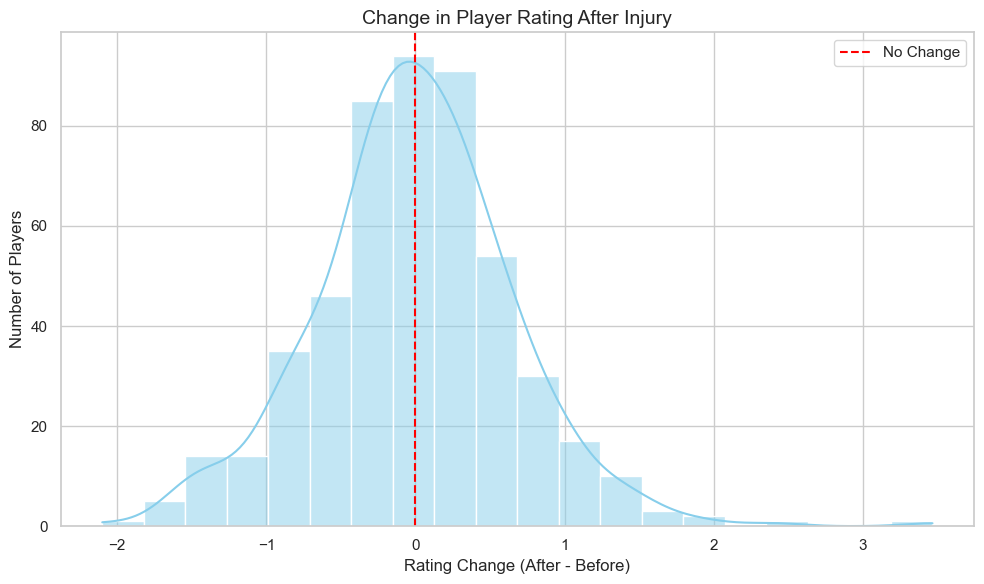

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing rating data and make an explicit copy
df_perf = df.dropna(subset=['Player_rating_before', 'Player_rating_after']).copy()

# Calculate rating change safely
df_perf['Rating Change'] = df_perf['Player_rating_after'] - df_perf['Player_rating_before']

# Plot change in player ratings after injury
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df_perf['Rating Change'], kde=True, bins=20, color='skyblue')
plt.title("Change in Player Rating After Injury", fontsize=14)
plt.xlabel("Rating Change (After - Before)", fontsize=12)
plt.ylabel("Number of Players", fontsize=12)
plt.axvline(0, color='red', linestyle='--', label='No Change')
plt.legend()
plt.tight_layout()
plt.show()



In [23]:
# Top performers after injury
top_recoveries = df_perf.sort_values(by='Player_rating_after', ascending=False).head(10)
print("🏅 Top Post-Injury Performers:")
print(top_recoveries[['Name', 'Injury Duration', 'Player_rating_before', 'Player_rating_after']])


🏅 Top Post-Injury Performers:
                 Name  Injury Duration  Player_rating_before  \
402       Richarlison               23              6.400000   
475  Giovani Lo Celso               36              6.700000   
307        Paul Pogba               42              6.533333   
482         Nick Pope                7              7.133333   
81    Bruno Guimarães               22              6.800000   
105       Sven Botman               19              6.833333   
614        Moise Kean                8              5.400000   
405   Sergio Reguilon                7              6.966667   
198   Martin Ødegaard               19              7.066667   
60      Jonjo Shelvey                9              6.666667   

     Player_rating_after  
402             8.366667  
475             8.100000  
307             7.900000  
482             7.833333  
81              7.800000  
105             7.800000  
614             7.800000  
405             7.733333  
198             7.7333

In [24]:
gems = df_perf[(df_perf['Player_rating_before'] < 6.0) & (df_perf['Player_rating_after'] >= 7.0)]
print("💎 Hidden Gems (Improved Post-Injury):")
print(gems[['Name', 'Player_rating_before', 'Player_rating_after']])


💎 Hidden Gems (Improved Post-Injury):
                      Name  Player_rating_before  Player_rating_after
117          Harvey Barnes              5.966667             7.466667
156     Gabriel Martinelli              5.733333             7.050000
269          Harry Maguire              5.966667             7.000000
320        Bruno Fernandes              3.933333             7.400000
400            Richarlison              5.800000             7.400000
558             Yerry Mina              5.900000             7.033333
564             Yerry Mina              5.800000             7.100000
578    Morgan Schneiderlin              5.733333             7.066667
614             Moise Kean              5.400000             7.800000
618  Dominic Calvert-Lewin              5.500000             7.333333


In [25]:
# Flag players with long injuries
df['High Risk Injury'] = df['Injury Duration'] > 60  # more than 2 months

# Summary
risk_summary = df['High Risk Injury'].value_counts()
print("Risk Distribution:\n", risk_summary)


Risk Distribution:
 High Risk Injury
False    512
True     144
Name: count, dtype: int64


In [26]:
def player_report(name):
    p = df[df['Name'].str.contains(name, case=False)]
    if p.empty:
        print("Player not found.")
    else:
        print("📊 Player Profile:")
        print(p[['Name', 'Date of Injury', 'Date of return', 'Injury Duration', 'Player_rating_before', 'Player_rating_after']])

# Example
player_report("Isak")


📊 Player Profile:
               Name Date of Injury Date of return  Injury Duration  \
85   Alexander Isak     2022-09-20     2022-12-01               72   
111  Alexander Isak     2023-10-25     2022-12-01             -328   
112  Alexander Isak     2024-01-30     2022-12-01             -425   

     Player_rating_before  Player_rating_after  
85               6.766667             6.566667  
111              7.000000             6.233333  
112              6.866667             6.566667  


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

model_df = df_perf[['Player_rating_before', 'Injury Duration', 'Player_rating_after']].dropna()
X = model_df[['Player_rating_before', 'Injury Duration']]
y = model_df['Player_rating_after']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, y_train)

print("Model Coefficients:", reg.coef_)
print("Model Intercept:", reg.intercept_)
print("R² Score:", reg.score(X_test, y_test))


Model Coefficients: [2.60601526e-01 1.35838339e-04]
Model Intercept: 4.735841713395413
R² Score: 0.11607838752691424
